In [25]:
import pandas as pd
import numpy as np

# save model
import os
import pickle

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
import matplotlib.pyplot as plt

from yellowbrick.cluster import KElbowVisualizer

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from pyclustering.cluster.xmeans import xmeans as XMeans
import time

from sklearn import metrics

# Load Cleaned Data

In [2]:
data = pd.read_csv('clean_tweets.tsv', sep='\t')
data.head()

,Unnamed: 0,Unnamed: 0.1,id_str,from_user,text,created_at,time,geo_coordinates,user_lang,in_reply_to_user_id_str,in_reply_to_screen_name,from_user_id_str,in_reply_to_status_id_str,source,profile_image_url,user_followers_count,user_friends_count,user_location,status_url,entities_str
0,0,0,1417635429579247617,Kosasih0706,lama tolak vaksin abai dulu,Tue Jul 20 23:59:59 +0000 2021,21/07/2021 00:59:59,NaN,NaN,1.416723955424002e+18,H4CKN3T_,9.343577e+17,1.417449e+18,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1313265976...,68.0,159.0,NaN,http://twitter.com/Kosasih0706/statuses/141763...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
1,1,1,1417635417269051392,frhikma,bandara soeta sedia layan vaksin bagaimana pro...,Tue Jul 20 23:59:56 +0000 2021,21/07/2021 00:59:56,NaN,NaN,994248960.0,frhikma,9.942490e+08,1.417634e+18,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1415948130...,376.0,317.0,"Tangerang, Indonesia",http://twitter.com/frhikma/statuses/1417635417...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[]..."
2,2,2,1417635413716389889,dynayum,allah selamat hoax baru vaksin rubah dna buat ...,Tue Jul 20 23:59:55 +0000 2021,21/07/2021 00:59:55,NaN,NaN,NaN,NaN,5.579809e+07,NaN,"<a href=""https://mobile.twitter.com"" rel=""nofo...",http://pbs.twimg.com/profile_images/1415156494...,503.0,313.0,NaN,http://twitter.com/dynayum/statuses/1417635413...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."
3,3,3,1417635409480216580,estywukak,bantu ibu jawab iya ibu vaksin sinovac suntik ...,Tue Jul 20 23:59:54 +0000 2021,21/07/2021 00:59:54,NaN,NaN,NaN,NaN,2.994025e+08,NaN,"<a href=""http://twitter.com/download/android"" ...",http://pbs.twimg.com/profile_images/1399574428...,1639.0,3666.0,"Nusa Tenggara Timur, Indonesia",http://twitter.com/estywukak/statuses/14176354...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[]..."
4,4,4,1417635391927033856,zaqhisyam,bibi positif covid sempat vaksin tahan vaksin ...,Tue Jul 20 23:59:50 +0000 2021,21/07/2021 00:59:50,NaN,NaN,NaN,NaN,1.187276e+08,NaN,"<a href=""http://twitter.com/download/iphone"" r...",http://pbs.twimg.com/profile_images/1392746882...,422.0,457.0,"Kelang, Selangor",http://twitter.com/zaqhisyam/statuses/14176353...,"{""hashtags"":[],""symbols"":[],""user_mentions"":[{..."


In [3]:
data.text[121]

'cara sederhana saturasi oksigen rendah pasien covid sedang isolasi diri perlu tahu'

In [4]:
pd.to_datetime(data.drop(index=3628).created_at)

0      2021-07-20 23:59:59+00:00
1      2021-07-20 23:59:56+00:00
2      2021-07-20 23:59:55+00:00
3      2021-07-20 23:59:54+00:00
4      2021-07-20 23:59:50+00:00
                  ...           
8780   2021-07-27 08:41:02+00:00
8781   2021-07-27 08:41:00+00:00
8782   2021-07-27 08:41:00+00:00
8783   2021-07-27 08:40:59+00:00
8784   2021-07-27 08:40:58+00:00
Name: created_at, Length: 8784, dtype: datetime64[ns, UTC]

In [5]:
len(data)

8785

In [6]:
data.duplicated('text').sum()

0

Ambil data yang kalimatnya lebih dari 2 kata

In [7]:
word_count = pd.Series(list(map(lambda x: len(str(x).split(" ")), data.text)))

word_count.describe()

count    8785.000000
mean       13.573591
std         8.377089
min         1.000000
25%         7.000000
50%        12.000000
75%        20.000000
max        55.000000
dtype: float64

In [8]:
data = data.loc[word_count > 2]
len(data)

8537

# Term Frequencies
TF (*Term Frequency*) adalah frekuensi dari kemunculan sebuah istilah dalam dokumen yang bersangkutan. Semakin besar jumlah kemunculan suatu term (TF tinggi) dalam dokumen, semakin besar pula bobotnya atau akan memberikan nilai keseuaian yang semakin besar. Berikut rumusnya:

$$
tf_{i,j} = \frac{n_{i,j}}{\sum_{k}n_{i,j}}
$$

Semerntara itu IDF merupakan sebuah perhitungan dari bagaimana term didistribusikan secara luas pada koleksi dokumen yang bersangkutan. IDF menunjukkan hubungan ketersediaan sebuah istilah dalam seluruh dekomuen. Semakin sedikit jumlah dokumen yang mengandung term yang dimaksud, maka nilai IDF semakin besar. IDF dihitung dengan:

$$
idf(w) = log(\frac{N}{df_{t}})
$$

Dengan mengombinasikan dua persamaan diatas kita dapat menemukan kata yang penting dalam dokumen (tweet). Rumus TF-IDF score adalah:

$$
w_{i,j} = tf_{i,j} * log(\frac{N}{df_{t}})
$$

---
**Referensi**
- [Text Mining dengan K-Means Clustering pada Tema LGBT dalam Arsip Tweet Masyarakat Kota Bandung](https://core.ac.uk/download/pdf/235583628.pdf)

In [9]:
# Untuk mengaplikasikan tf-idf, inputnya harus berupa list of tweet
tweets = data.text.to_list()
tweets[112:119]

['halo huan ying guan ling kenal julya chatime staff jababeka mau kasih tau kalau chatime banyak promo tau nya mulai promonya nampilin kartu vaksin nya dapet minum harga murah murah',
 'saran semua ppv lihat benar minta vaksinator hindar human error tipu moga jkjav lindung sehat atur sop percaya masyarakat program vaksinasi',
 'lebih satu juta lebih populasi terima dosis tunggal jumlah hampir satu juta lebih populasi dosis lengkap vaksinasi cara keluar pandemi cara konsisten praktik tindak sehat masyarakat',
 'cara sederhana saturasi oksigen rendah pasien covid sedang isolasi diri perlu tahu',
 'q list lho sdhan by link vaksin nusantara',
 'talok e dry hit the vaksin',
 'hari vaksin kemarin badan turun sakit tenggorok tahan benar badan cepat lelah minum vitamin obat flu makin hari suara mulai serak batuk alhamdulillah makin hari makin baik']

In [10]:
tfidf = TfidfVectorizer(max_features=None,
                       max_df=0.2,
                       min_df=5,
                       ngram_range=(1,2))
features = tfidf.fit_transform(tweets)

print(features.shape)

(8537, 4714)


## Term Document Matrix Untuk Pembobotan TF-IDF

In [9]:
tdm_tfidf = pd.DataFrame(features.toarray(), index=['tweet ' + str(i+1) for i in range(len(data))])
tdm_tfidf.columns = tfidf.get_feature_names()
tdm_tfidf.head()

,aaa,abai,abang,abdi,acara,acara vaksinasi,ad,adakan,adha,adik,...,yo,yogyakarta,you,your,youtube,yuk,zaman,zeneca,zona,zoo
tweet 1,0.0,0.564896,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 2,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.227944,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 3,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 4,0.0,0.000000,0.189054,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
tweet 5,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
tdm_tfidf.sum(axis=1).sort_values()

arief sulistyanto      0.789495
massal isolasi         0.789495
rangka kece            0.789495
dr had                 0.789495
komjen pol             0.789495
                        ...    
jadi                 116.407665
mau                  136.077679
hari                 158.196383
orang                159.989962
covid                161.763726
Length: 4714, dtype: float64

## Term Document Matrix Untuk TF

In [ ]:
tf = CountVectorizer(max_features=None,
                    max_df=0.2,
                    min_df=5)
vects = tf.fit_transform(data.text)

In [ ]:
td = pd.DataFrame(vects.todense())
td

,0,1,2,3,4,5,6,7,8,9,...,2304,2305,2306,2307,2308,2309,2310,2311,2312,2313
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8532,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8533,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8534,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8535,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
td.columns = tf.get_feature_names() # namain judul kolom jadi setiap kata
tdm_tf = td.T # transpose
# namain judul kolom (setelah di transpose) menjadi
# tweet 1, tweet 2, dst, sepanjang banyaknya tweet
tdm_tf.columns = ['tweet ' + str(i+1) for i in range(len(td))]
tdm_tf['total_count'] = tdm_tf.sum(axis=1) # total kata

In [ ]:
tdm_tf.head()

,tweet 1,tweet 2,tweet 3,tweet 4,tweet 5,tweet 6,tweet 7,tweet 8,tweet 9,tweet 10,...,tweet 8529,tweet 8530,tweet 8531,tweet 8532,tweet 8533,tweet 8534,tweet 8535,tweet 8536,tweet 8537,total_count
aaa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
abai,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,20
abang,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,11
abdi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,6
acara,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,32


In [ ]:
# top 50 kata
word_freq = tdm_tf.sort_values(by='total_count', ascending=False)
word_freq.head()

,tweet 1,tweet 2,tweet 3,tweet 4,tweet 5,tweet 6,tweet 7,tweet 8,tweet 9,tweet 10,...,tweet 8529,tweet 8530,tweet 8531,tweet 8532,tweet 8533,tweet 8534,tweet 8535,tweet 8536,tweet 8537,total_count
covid,0,0,0,0,1,0,0,2,0,0,...,0,2,0,0,0,1,0,0,0,1429
orang,0,1,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,1355
hari,0,0,0,0,0,0,0,0,0,2,...,0,1,0,0,0,0,0,0,0,972
mau,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,902
jadi,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,878


### Visualisasi TF

In [ ]:
word_freq.iloc[:50,-1].plot(kind="bar",
                           figsize=(10,5),
                           colormap='Set2',
                           title="Top 50 Kata")

NameError: ignored

In [ ]:
# visualisasi wordcloud
wordcloud = WordCloud(background_color='white', max_words=2000,
                     width=1024, height=720)
plt.figure(figsize=(20,8))
plt.title('Wordcloud TF')
plt.imshow(wordcloud.generate_from_frequencies(word_freq.iloc[:,-1].to_dict()))
plt.axis('off')
plt.show

# Clustering

In [12]:
# fit clustering
terms = tfidf.get_feature_names()
K = 10

def fit_clustering(model, tfidf_matrix=features):
    t0 = time.time()
    try:
        model.fit(tfidf_matrix)
    except AttributeError:
        model.process()
    t1 = time.time() - t0

    print("Top terms per cluster:")
    try:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    except AttributeError:
        try:
            order_centroids = model.cluster_centers_.toarray().argsort()[:, ::-1]
        except AttributeError:
            order_centroids = np.array(model.get_centers()).argsort()[:, ::-1]

    for i in range(K):
        print("Cluster %d:" % i),
        for ind in order_centroids[i, :K]:
            print(' %s' % terms[ind]),
        print()
        
    return model, t1

In [13]:
# saving model
def save_model(filename, model):
    os.makedirs(os.path.dirname("dumps/trained_models/"), exist_ok=True)

    with open('dumps/trained_models/' + filename, 'wb') as f:
        pickle.dump(model, f)
        f.close()

# loading model
def load_model(filename):
    with open('dumps/trained_models/' + filename, 'rb') as f:
        return pickle.load(f)

In [65]:
# labelling

# getting top 10 features
def get_top_features(model):
    top_10_features = []
    current_cluster = []
    try:
        order_centroids = model.cluster_centers_.argsort()[:, ::-1]
    except AttributeError:
        try:
            order_centroids = model.cluster_centers_.toarray().argsort()[:, ::-1]
        except AttributeError:
            order_centroids = np.array(model.get_centers()).argsort()[:, ::-1]

    for i in range(K):
        for ind in order_centroids[i, :10]:
            current_cluster.append(terms[ind])
        top_10_features.append(current_cluster)
        current_cluster = []
    
    return top_10_features

# create topic table
def create_topic_table(model):
    table = pd.DataFrame({"terms": get_top_features(model), "cluster": range(K)})
    table.terms = table.terms.apply(lambda x : ", ". join(x))
    
    return table

In [48]:
# create plot
def create_plot(model, tfidf_matrix, title):
    pca = PCA(n_components=2)
    scatter_plot_points = pca.fit_transform(tfidf_matrix.toarray())
    try:
        centroid_plot = pca.fit_transform(model.cluster_centers_)
    except TypeError:
        centroid_plot = pca.fit_transform(model.cluster_centers_.toarray())

    
    labels = model.labels_
    unique_labels = set(labels)
    colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
    
    for k, col in zip(unique_labels, colors):
        class_member_mask = labels == k
        
        xy = scatter_plot_points[class_member_mask]
        plt.plot(
            xy[:, 0],
            xy[:, 1],
            "o",
            markerfacecolor=tuple(col),
            markeredgecolor="k",
            markersize=6,
        )

    plt.plot(
        centroid_plot[:, 0],
        centroid_plot[:, 1],
        "o",
        markerfacecolor="cyan",
        markeredgecolor="k",
        markersize=10,
    )

    plt.title(title)


In [16]:
# worcloud visualization
def create_wordcloud(result_table):
    fig, ax = plt.subplots(5, 2, figsize=(10,15))
    for i in range(K):
        idx = i % 5
        idy = i // 5

        s = result_table[result_table.cluster == i]
        text = s['tweet'].str.cat(sep=' ')
        text = text.lower()
        text = ' '.join([word for word in text.split()])
        wordcloud = WordCloud(max_font_size=50, max_words=100,
                             background_color='white').generate(text)

        ax[idx, idy].imshow(wordcloud, interpolation='bilinear')
        ax[idx, idy].axis('off')
        ax[idx, idy].set_title("Cluster" + str(i))

## K-Means Clustering

### Find Best Number of Cluster

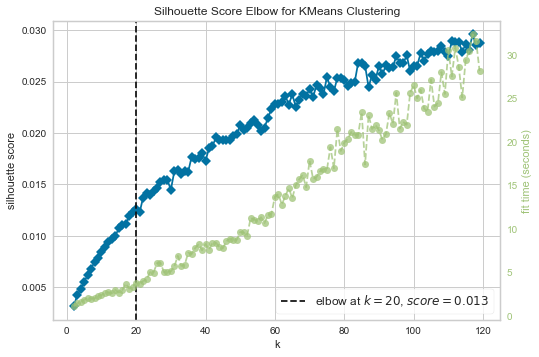

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [54]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(algorithm='full'), k=(2,120), metric='silhouette', timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

Sekaligus hitung waktu trainingnya untuk digunakan pada bagian evaluasi

In [55]:
KMeans?

Init signature:
KMeans(
    n_clusters=8,
    *,
    init='k-means++',
    n_init=10,
    max_iter=300,
    tol=0.0001,
    precompute_distances='deprecated',
    verbose=0,
    random_state=None,
    copy_x=True,
    n_jobs='deprecated',
    algorithm='auto',
)
Docstring:     
K-Means clustering.

Read more in the :ref:`User Guide <k_means>`.

Parameters
----------

n_clusters : int, default=8
    The number of clusters to form as well as the number of
    centroids to generate.

init : {'k-means++', 'random'}, callable or array-like of shape             (n_clusters, n_features), default='k-means++'
    Method for initialization:

    'k-means++' : selects initial cluster centers for k-mean
    clustering in a smart way to speed up convergence. See section
    Notes in k_init for more details.

    'random': choose `n_clusters` observations (rows) at random from data
    for the initial centroids.

    If an array is passed, it should be of shape (n_clusters, n_features)
    and gives

In [50]:
K = 11
kmeans, kmeans_time = fit_clustering(
    KMeans(K, random_state=1, algorithm='full'),
    features
)

Top terms per cluster:
Cluster 0:
 jadi
 vaksin jadi
 jadi vaksin
 jangan
 vaksinasi jadi
 bukan
 orang
 buat
 sekarang
 lebih
 bulan

Cluster 1:
 covid
 sehat
 vaksin covid
 vaksinasi covid
 cepat
 masyarakat
 patuh
 ppkm
 pandemi
 perintah
 indonesia

Cluster 2:
 dosis
 dosis vaksin
 vaksin dosis
 dosis pertama
 pertama
 terima
 juta
 juta dosis
 selesai
 juli
 selesai dosis

Cluster 3:
 kalau
 daftar
 sertifikat
 jangan
 baru
 sakit
 banyak
 lebih
 terima
 bulan
 sinovac

Cluster 4:
 apa
 apa apa
 vaksin apa
 apa laku
 laku
 apa vaksin
 kalau
 kamu
 orang
 efek
 buat

Cluster 5:
 benar
 benar benar
 vaksin benar
 memang benar
 memang
 benar vaksin
 orang
 sakit
 bukan
 hari
 vaksinasi benar

Cluster 6:
 orang
 banyak
 orang orang
 banyak orang
 orang vaksin
 semua
 covid
 semua orang
 orang vaksinasi
 tinggal
 tua

Cluster 7:
 hari
 hari vaksin
 vaksin hari
 hari vaksinasi
 vaksinasi hari
 tiap hari
 tiap
 hari hari
 baru
 aku
 moga

Cluster 8:
 pagi
 selamat pagi
 selamat
 hari
 pa

In [ ]:
save_model('kmeans_11cluster.model', kmeans)

In [38]:
kmeans = load_model('kmeans.model')

### Labelling

In [51]:
create_topic_table(kmeans)

,terms,cluster
0,"jadi, vaksin jadi, jadi vaksin, jangan, vaksin...",0
1,"covid, sehat, vaksin covid, vaksinasi covid, c...",1
2,"dosis, dosis vaksin, vaksin dosis, dosis perta...",2
3,"kalau, daftar, sertifikat, jangan, baru, sakit...",3
4,"apa, apa apa, vaksin apa, apa laku, laku, apa ...",4
5,"benar, benar benar, vaksin benar, memang benar...",5
6,"orang, banyak, orang orang, banyak orang, oran...",6
7,"hari, hari vaksin, vaksin hari, hari vaksinasi...",7
8,"pagi, selamat pagi, selamat, hari, pagi hari, ...",8
9,"mau, mau vaksin, kalau, kalau mau, dulu, hari,...",9


In [ ]:
labelled_cluster = pd.read_csv('top 10 fitur per cluster labelled.tsv', sep='\t')
topic_dict = {}
topic_names = labelled_cluster.topik.values
for i in range(len(labelled_cluster)):
    topic_dict[i]=topic_names[i]

In [ ]:
topic_dict

In [ ]:
result = {'cluster': model.labels_, 'tweet': tweets}


In [ ]:
model.labels_

### Plotting Cluster

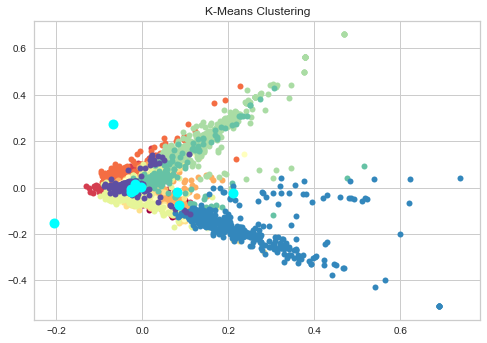

In [52]:
create_plot(kmeans, features, 'K-Means Clustering')

### Wordcloud per cluster

IndexError: index 2 is out of bounds for axis 1 with size 2

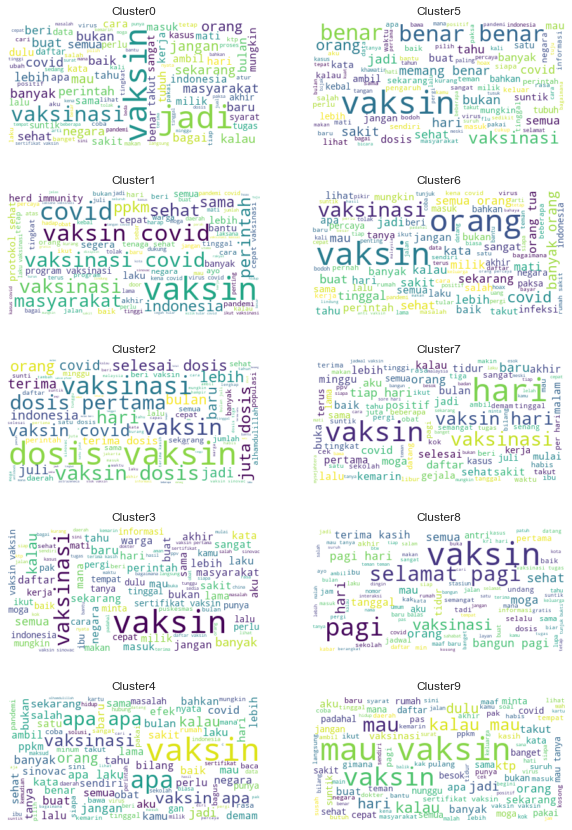

In [53]:
result_kmeans = pd.DataFrame({"tweet": tweets, "cluster": kmeans.labels_})

create_wordcloud(result_kmeans)

In [20]:
result_kmeans.cluster.value_counts()

6    4101
3     855
4     747
7     707
8     413
9     406
2     391
1     374
0     316
5     227
Name: cluster, dtype: int64

## K-Medoids Clustering

### Find Best Number of Cluster

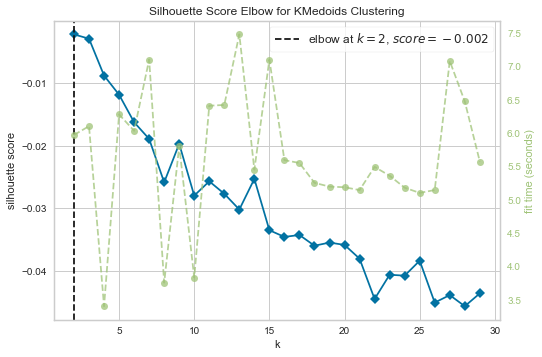

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMedoids Clustering'}, xlabel='k', ylabel='silhouette score'>

In [21]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMedoids(init='k-medoids++'), k=(2,30), metric='silhouette', timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

In [34]:
kmedoids, kmedoids_time = fit_clustering(
    KMedoids(K, random_state=1, init='k-medoids++', method='pam'),
    features
)

Top terms per cluster:
Cluster 0:
 zoo
 jejak
 jasa
 jatah
 jatah vaksin
 jatim
 jatuh
 jatuh sakit
 jauh
 jauh lebih

Cluster 1:
 hari vaksin
 hari
 jaya
 jauh
 jasa
 jatah
 jatah vaksin
 jatim
 jatuh
 jatuh sakit

Cluster 2:


IndexError: index 2 is out of bounds for axis 0 with size 2

In [37]:
kmedoids = load_model('kmedoids.model')

### Labelling

In [38]:
create_topic_table(kmedoids)

,terms,cluster
0,"zoo, jejak, jasa, jatah, jatah vaksin, jatim, ...",0
1,"hari vaksin, hari, jaya, jauh, jasa, jatah, ja...",1
2,"kg, besut, darurat lokasi, vaksin proklamasi, ...",2
3,"lupa vaksin, jangan lupa, lupa, jangan, zoo, j...",3
4,"mau vaksin, mau, zoo, jasa, jatah, jatah vaksi...",4
5,"semangat vaksin, semangat, jatuh sakit, jarum,...",5
6,"tanggal vaksin, tanggal, jatuh, jaring, jarum,...",6
7,"vaksin hari, hari, jarum suntik, jasa, jatah, ...",7
8,"anti vaksin, anti, jarum suntik, jatah, jatah ...",8
9,"hari vaksinasi, hari, jasa, jatah, jatah vaksi...",9


### Plotting Cluster

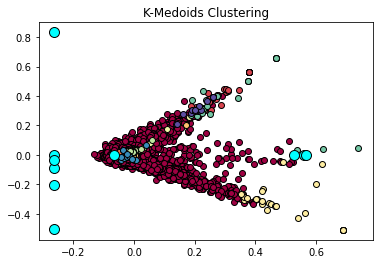

In [41]:
create_plot(kmedoids, features, 'K-Medoids Clustering')

### Wordcloud per cluster

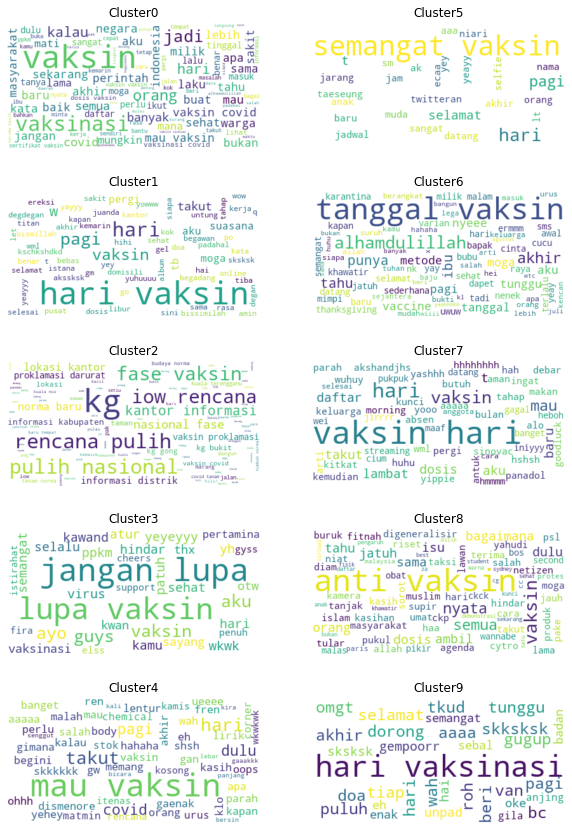

In [42]:
result_kmedoids = pd.DataFrame({"tweet": tweets, "cluster": kmedoids.labels_})

create_wordcloud(result_kmedoids)

In [25]:
result_kmedoids.cluster.value_counts()

0    8319
1      36
2      32
6      29
7      27
4      27
8      20
9      18
3      15
5      14
Name: cluster, dtype: int64

## Accelerated K-Means

### Find Best Number of Cluster

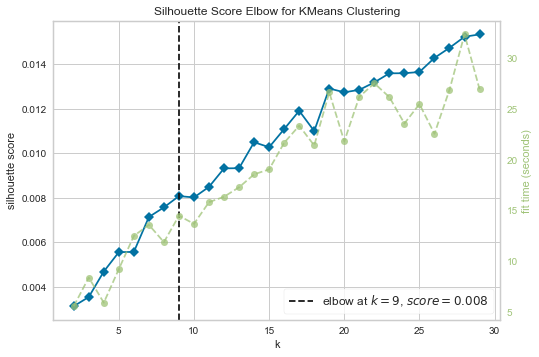

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [22]:
# k is range of number of clusters.
visualizer = KElbowVisualizer(KMeans(algorithm='elkan'), k=(2,30), metric='silhouette', timings=True)
visualizer.fit(features)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

### Training

In [43]:
acc_kmeans, acc_kmeans_time = fit_clustering(
    KMeans(K, random_state=1, algorithm='elkan'),
    features
)

Top terms per cluster:
Cluster 0:
 apa
 apa apa
 vaksin apa
 apa laku
 laku
 apa vaksin
 jadi
 kalau
 kamu
 orang

Cluster 1:
 sehat
 jangan
 patuh
 ppkm
 tenaga
 lupa
 tenaga sehat
 protokol
 protokol sehat
 jangan lupa

Cluster 2:
 mau
 mau vaksin
 kalau
 kalau mau
 hari
 hari mau
 vaksin mau
 dulu
 takut
 jadi

Cluster 3:
 covid
 vaksin covid
 vaksinasi covid
 door
 cepat
 herd immunity
 immunity
 herd
 anak
 virus

Cluster 4:
 jadi
 kalau
 daftar
 sakit
 baru
 lebih
 banyak
 bulan
 pagi
 benar

Cluster 5:
 sertifikat
 sertifikat vaksin
 syarat
 vaksin sertifikat
 kartu
 kalau
 cek
 sertifikat vaksinasi
 mau
 ktp

Cluster 6:
 informasi
 terima
 kasih
 terima kasih
 kg
 informasi vaksin
 terima vaksin
 fase
 iow
 pulih nasional

Cluster 7:
 orang
 banyak
 orang orang
 banyak orang
 orang vaksin
 semua
 jadi
 covid
 orang vaksinasi
 semua orang

Cluster 8:
 dosis
 dosis vaksin
 dosis pertama
 vaksin dosis
 pertama
 juta
 terima
 selesai
 juta dosis
 selesai dosis

Cluster 9:
 hari
 ha

In [36]:
acc_kmeans = load_model('acc_kmeans.model')

### Labelling

In [44]:
create_topic_table(acc_kmeans)

,terms,cluster
0,"apa, apa apa, vaksin apa, apa laku, laku, apa ...",0
1,"sehat, jangan, patuh, ppkm, tenaga, lupa, tena...",1
2,"mau, mau vaksin, kalau, kalau mau, hari, hari ...",2
3,"covid, vaksin covid, vaksinasi covid, door, ce...",3
4,"jadi, kalau, daftar, sakit, baru, lebih, banya...",4
5,"sertifikat, sertifikat vaksin, syarat, vaksin ...",5
6,"informasi, terima, kasih, terima kasih, kg, in...",6
7,"orang, banyak, orang orang, banyak orang, oran...",7
8,"dosis, dosis vaksin, dosis pertama, vaksin dos...",8
9,"hari, hari vaksin, vaksin hari, hari vaksinasi...",9


### Plotting Cluster

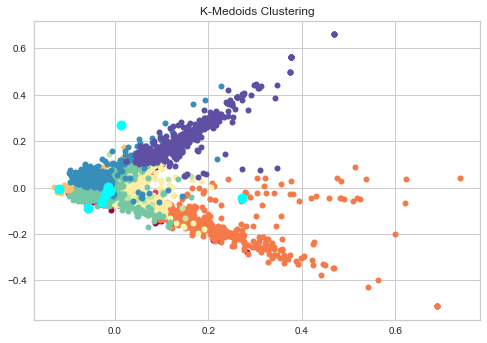

In [47]:
create_plot(acc_kmeans, features, 'Accelerated K-Means Clustering')

### Wordcloud per cluster

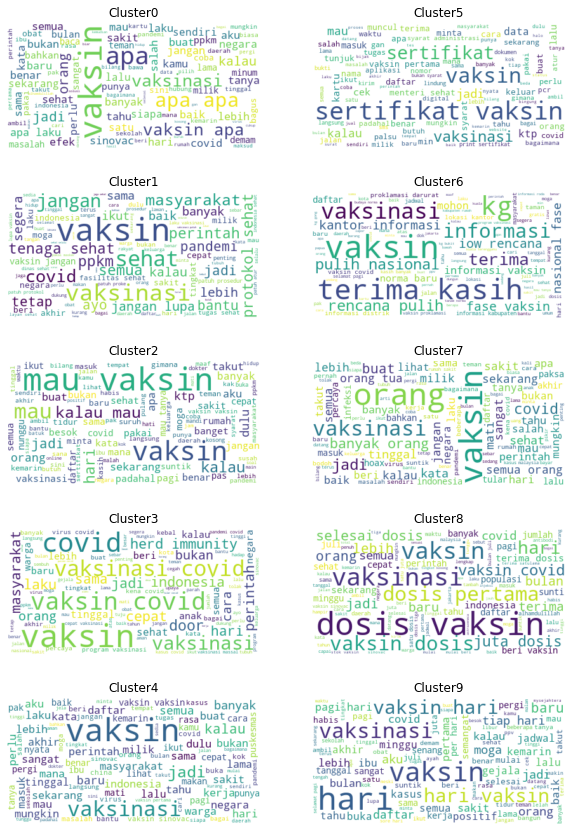

In [45]:
result_acc_kmeans = pd.DataFrame({"tweet": tweets, "cluster": acc_kmeans.labels_})

create_wordcloud(result_acc_kmeans)

In [31]:
result_acc_kmeans.cluster.value_counts()

4    4396
3     822
7     740
1     543
8     407
9     401
2     396
0     332
6     271
5     229
Name: cluster, dtype: int64

## X-Means

### Find Best Number of Cluster

In [ ]:
silhouette_scores = []
max_K = 30
initial_centers = kmeans_plusplus_initializer(features.todense(), K).initialize()
for i in range(2,30):
    xmeans_model = XMeans(features.todense(), initial_centers, K)
    xmeans_model.process()
    silhouette_scores.append(metrics.silhouette_score())
    
    result_xmeans = pd.DataFrame(columns=['tweet', 'cluster'])
    for cluster_num, cluster in enumerate(xmeans.get_clusters()):
        for tweet_index in cluster:
            result_xmeans = result_xmeans.append({'tweet': tweets[tweet_index], 'cluster': cluster_num}, ignore_index=True)

### Training

In [47]:
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer

t0 = time.time()
initial_centers = kmeans_plusplus_initializer(features.todense(), K).initialize()
xmeans, _ = fit_clustering(XMeans(features.todense(), initial_centers, K))
xmeans_time = time.time() - t0

Top terms per cluster:
Cluster 0:
 orang
 jadi
 sehat
 banyak
 benar
 daftar
 semua
 dosis
 terima
 pagi

Cluster 1:
 pertama
 efek
 vaksin pertama
 dosis
 dosis pertama
 efek samping
 samping
 efek vaksin
 vaksin dosis
 sakit

Cluster 2:
 covid
 vaksin covid
 vaksinasi covid
 orang
 sehat
 mati
 virus
 kena
 covid vaksin
 kena covid

Cluster 3:
 jangan
 kalau
 antri
 dulu
 buat
 baru
 antri vaksin
 lupa
 orang
 jangan lupa

Cluster 4:
 negara
 beli
 uang
 rakyat
 jual
 beli vaksin
 orang
 banyak
 china
 perintah

Cluster 5:
 cepat
 program
 herd immunity
 herd
 immunity
 masyarakat
 massal
 door
 dukung
 program vaksinasi

Cluster 6:
 paling
 foto
 ktp
 bawa
 vaksin paling
 kartu
 orang
 dekat
 teman
 tugas

Cluster 7:
 hari
 hari vaksin
 vaksin hari
 hari vaksinasi
 vaksinasi hari
 pagi
 pagi hari
 tiap hari
 tiap
 aku

Cluster 8:
 apa
 apa apa
 vaksin apa
 laku
 orang
 apa laku
 apa vaksin
 jadi
 benar
 kalau

Cluster 9:
 mau
 mau vaksin
 kalau
 kalau mau
 hari
 dulu
 hari mau
 vaks

In [20]:
xmeans = load_model('xmeans.model')

### Labelling

In [66]:
create_topic_table(xmeans)

,terms,cluster
0,"hari, hari vaksin, vaksin hari, hari vaksinasi...",0
1,"jangan, negara, tanggal, tanggal vaksin, lupa,...",1
2,"sehat, ayo, patuh, protokol, protokol sehat, t...",2
3,"jadi, apa, dosis, kalau, baru, pertama, sakit,...",3
4,"bulan, juli, bulan juli, vaksin bulan, dosis, ...",4
5,"mau, mau vaksin, kalau, kalau mau, hari, dulu,...",5
6,"surat, surat vaksin, surat terang, terang, min...",6
7,"covid, vaksin covid, vaksinasi covid, cepat, p...",7
8,"mana, mana vaksin, mana mana, vaksin mana, tem...",8
9,"orang, banyak, orang orang, banyak orang, oran...",9


### Wordcloud per cluster

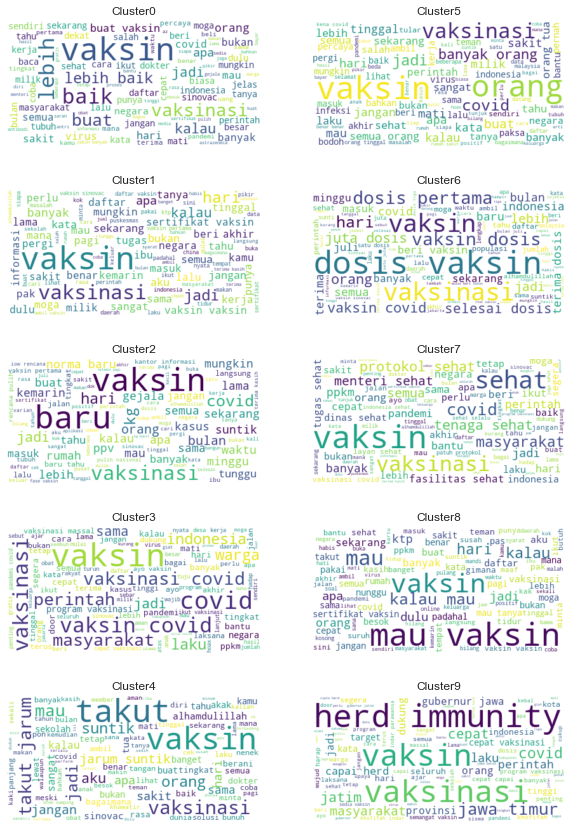

In [27]:
result_xmeans = pd.DataFrame(columns=['tweet', 'cluster'])

for cluster_num, cluster in enumerate(xmeans.get_clusters()):
    for tweet_index in cluster:
        result_xmeans = result_xmeans.append({'tweet': tweets[tweet_index], 'cluster': cluster_num}, ignore_index=True)
        
create_wordcloud(result_xmeans)

In [34]:
tweets_df = pd.DataFrame({'tweet': tweets})
result_xmeans = tweets_df.join(result_xmeans.set_index('tweet'), on='tweet')
# tweets_df

In [78]:
result_xmeans.cluster.value_counts()

0    4363
1     974
8     775
9     753
5     447
4     358
7     333
2     236
3     196
6     102
Name: cluster, dtype: int64

# Evaluation

## Clustering Performance

In [39]:
kmeans_labels = kmeans.labels_
kmedoids_labels = kmedoids.labels_
acc_kmeans_labels = acc_kmeans.labels_
xmeans_labels = result_xmeans.cluster.to_numpy()

model_labels_list = [kmeans_labels, kmedoids_labels, acc_kmeans_labels, xmeans_labels]
model_names = ['K-Means', 'K-Medoids', 'Accelerated K-Means', 'X-Means']

In [40]:
def metric_table(metric, model_labels, index=model_names, tfidf_matrix=features):
    metric_scores = []
    
    for i in model_labels:
        metric_scores.append(metric(tfidf_matrix, i))
    
    return pd.DataFrame({metric.__name__: metric_scores},
                       index=index)

### Silhouette Index

In [41]:
si_table = metric_table(metrics.silhouette_score, model_labels_list)
si_table

,silhouette_score
K-Means,0.008562
K-Medoids,-0.006039
Accelerated K-Means,0.008612
X-Means,0.006595


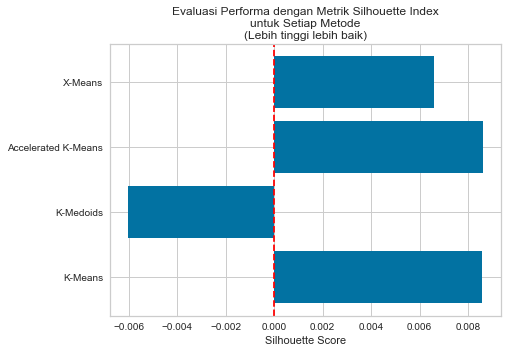

In [42]:
fig = plt.figure(figsize=(7,5))

plt.barh(range(len(si_table)), si_table.silhouette_score)
plt.yticks(range(len(si_table)), labels=model_names)
plt.axvline(x=0, color="red", linestyle="--")
plt.xlabel('Silhouette Score')
plt.title('Evaluasi Performa dengan Metrik Silhouette Index\nuntuk Setiap Metode\n(Lebih tinggi lebih baik)')

# fig.savefig('gambar/silhouette score.jpg', bbox_inches='tight', dpi=150)
plt.show()

### Davies-Bouldin Index

In [43]:
dbi_table = metric_table(metrics.davies_bouldin_score,
                         model_labels_list,
                         tfidf_matrix=features.toarray())
dbi_table

,davies_bouldin_score
K-Means,9.076691
K-Medoids,2.304506
Accelerated K-Means,8.592422
X-Means,9.531428


<AxesSubplot:title={'center':'Davies-Bouldin Index\n(lebih rendah lebih baik)'}>

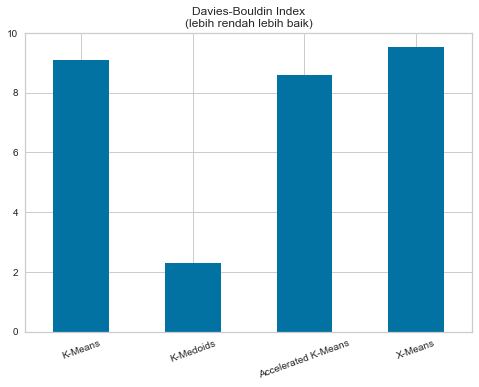

In [44]:
dbi_table.plot(kind='bar',
              legend=False,
              rot=20,
              title='Davies-Bouldin Index\n(lebih rendah lebih baik)')

<ipython-input-67-c2e132b3d0e0>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


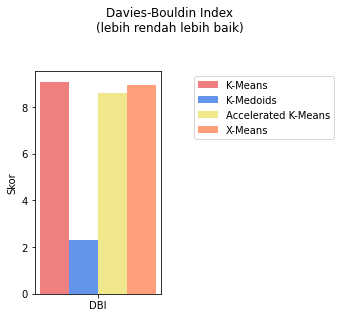

In [67]:
x = ['DBI']
sumbu_x = np.arange(len(x))
lebar = 0.1

fig = plt.figure(figsize=(5,9))
ax = fig.add_subplot(221)

bar1 = plt.bar(sumbu_x, [dbi_kmeans], lebar, color='lightcoral')
bar2 = plt.bar(sumbu_x+lebar, [dbi_kmedoids], lebar, color='cornflowerblue')
bar3 = plt.bar(sumbu_x+lebar*2, [dbi_acc_kmeans], lebar, color='khaki')
bar4 = plt.bar(sumbu_x+lebar*3, [dbi_xmeans], lebar, color='lightsalmon')

plt.ylabel('Skor')
plt.suptitle('Davies-Bouldin Index\n(lebih rendah lebih baik)')

plt.xticks(sumbu_x+lebar+lebar/2, x)
leg = plt.legend((bar1, bar2, bar3, bar4), ('K-Means', 'K-Medoids', 'Accelerated K-Means', 'X-Means'), loc='upper right')

# fig.savefig('gambar/dbi chi.jpg', bbox_inches='tight', dpi=150)
plt.draw()

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 1.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

# Update the plot
plt.show()

### Calinski-Harabasz Index

In [45]:
chi_table = metric_table(metrics.calinski_harabasz_score,
                        model_labels_list,
                        tfidf_matrix=features.toarray())
chi_table

,calinski_harabasz_score
K-Means,24.243959
K-Medoids,12.960916
Accelerated K-Means,24.505026
X-Means,20.085609


<AxesSubplot:title={'center':'Calinski-Harabasz Index\n(lebih tinggi lebih baik)'}>

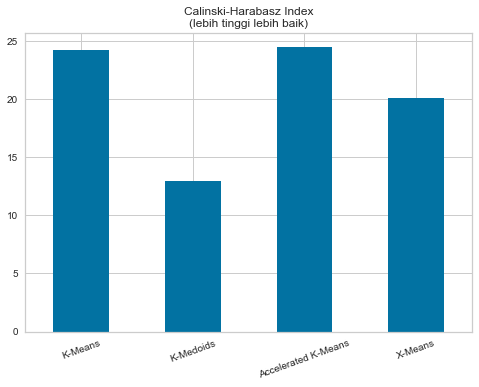

In [46]:
chi_table.plot(kind='bar',
              legend=False,
              rot=20,
              title='Calinski-Harabasz Index\n(lebih tinggi lebih baik)')

<ipython-input-68-3ff5094c3e20>:23: MatplotlibDeprecationWarning: 
The inverse_transformed function was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use transformed(transform.inverted()) instead.
  bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)


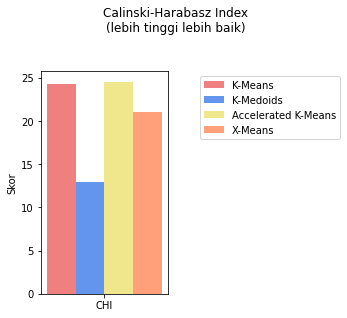

In [68]:
x = ['CHI']
sumbu_x = np.arange(len(x))
lebar = 0.1

fig = plt.figure(figsize=(5,9))
ax = fig.add_subplot(221)

bar1 = plt.bar(sumbu_x, [chi_kmeans], lebar, color='lightcoral')
bar2 = plt.bar(sumbu_x+lebar, [chi_kmedoids], lebar, color='cornflowerblue')
bar3 = plt.bar(sumbu_x+lebar*2, [chi_acc_kmeans], lebar, color='khaki')
bar4 = plt.bar(sumbu_x+lebar*3, [chi_xmeans], lebar, color='lightsalmon')

plt.ylabel('Skor')
plt.suptitle('Calinski-Harabasz Index\n(lebih tinggi lebih baik)')

plt.xticks(sumbu_x+lebar+lebar/2, x)
leg = plt.legend((bar1, bar2, bar3, bar4), ('K-Means', 'K-Medoids', 'Accelerated K-Means', 'X-Means'), loc='upper right')

# fig.savefig('gambar/dbi chi.jpg', bbox_inches='tight', dpi=150)
plt.draw()

# Get the bounding box of the original legend
bb = leg.get_bbox_to_anchor().inverse_transformed(ax.transAxes)

# Change to location of the legend. 
xOffset = 1.4
bb.x0 += xOffset
bb.x1 += xOffset
leg.set_bbox_to_anchor(bb, transform = ax.transAxes)

# Update the plot
plt.show()

## Waktu Eksekusi

Semua menggunakan 10 cluster

In [69]:
pd.DataFrame({"Waktu eksekusi": [kmeans_time, kmedoids_time, acc_kmeans_time, xmeans_time]},
            index=["K-Means", "K-Medoids", "Accelerated K-Means", "X-Means"])

,Waktu eksekusi
K-Means,4.475751
K-Medoids,339.081070
Accelerated K-Means,15.337470
X-Means,54.973689
